# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [13]:
# azdias.columns
azdias.index
# azdias.dtypes

RangeIndex(start=0, stop=891221, step=1)

In [11]:
feat_info.head()
# feat_info.shape
# feat_info.describe()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [12]:
azdias.shape[0]

891221

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

#### How much data is naturally missing?

In [27]:
# How many missing values there are in each column
azdias.isna().sum()

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [28]:
# List all the features having naturally missing data
features_with_naturally_missing = {}
for column in azdias:
    sum_isna = azdias[column].isna().sum()
    if sum_isna > 0:
        features_with_naturally_missing[column]= sum_isna  

In [29]:
# Number of features having naturally missing data
len(features_with_naturally_missing)

53

In [30]:
features_with_naturally_missing_sorted = sorted(features_with_naturally_missing, 
                                                key=features_with_naturally_missing.get, 
                                                reverse=True)
i = 1
for f in features_with_naturally_missing_sorted:
    print('{} - {} has {} naturally missing data, which represents {}% of the data'.format(
        i, 
        f, 
        features_with_naturally_missing[f], 
        round(features_with_naturally_missing[f] / azdias.shape[0] * 100, 2)))
    i += 1

1 - KK_KUNDENTYP has 584612 naturally missing data, which represents 65.6% of the data
2 - KBA05_ANTG1 has 133324 naturally missing data, which represents 14.96% of the data
3 - KBA05_ANTG2 has 133324 naturally missing data, which represents 14.96% of the data
4 - KBA05_ANTG3 has 133324 naturally missing data, which represents 14.96% of the data
5 - KBA05_ANTG4 has 133324 naturally missing data, which represents 14.96% of the data
6 - KBA05_BAUMAX has 133324 naturally missing data, which represents 14.96% of the data
7 - KBA05_GBZ has 133324 naturally missing data, which represents 14.96% of the data
8 - MOBI_REGIO has 133324 naturally missing data, which represents 14.96% of the data
9 - KKK has 121196 naturally missing data, which represents 13.6% of the data
10 - REGIOTYP has 121196 naturally missing data, which represents 13.6% of the data
11 - PLZ8_ANTG1 has 116515 naturally missing data, which represents 13.07% of the data
12 - PLZ8_ANTG2 has 116515 naturally missing data, which 

In [24]:
# Replace all the missing values by 0 - DO NOT DO THIS BECAUSE the value 0 has a meaning in several columns
# e.g. GREEN_AVANTGARDE, SHOPPER_TYP, SOHO_KZ
# azdias.fillna(0, inplace=True)

#### How much data takes on a 'missing' or 'unknown' code? Replace the 'missing' and 'unknown' codes by NaN

In [31]:
# Identify missing or unknown data values and convert them to NaNs.
features_with_missing_or_unknown = {}
for column in azdias:
    # missing or unknown values listed in feat_info.missing_or_unknown for feat_info.attribute = column
    missing_or_unknown_values = feat_info[feat_info.attribute == column].missing_or_unknown.values[0]
    missing_or_unknown_values = missing_or_unknown_values.replace('[','')
    missing_or_unknown_values = missing_or_unknown_values.replace(']','')
    list_missing_or_unknown_values = missing_or_unknown_values.split(',')
    
    # replace the missing or unknown values by NaN
    azdias.loc[azdias[column].isin(list_missing_or_unknown_values), column] = np.nan
    

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [59]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# List all the columns having at least one NaN value
count_NaN_by_column = {}
for column in azdias:
    count_NaN = azdias[column].isna().sum()
    if count_NaN > 0:
        count_NaN_by_column[column] = count_NaN  
        

In [60]:
# Sort the columns: on top the ones which have the highest occurence of NaN
sorted_columns = sorted(count_NaN_by_column, 
                        key=count_NaN_by_column.get, 
                        reverse=True)

In [79]:
# Investigate patterns in the amount of missing data in each column.
print('Here are the outlier columns:\n')
i = 0
for column in sorted_columns:
    print('{} : {} : {} : {}% missing data'.format(i, column, 
                                 count_NaN_by_column[column], 
                                 round(count_NaN_by_column[column] / azdias.shape[0] * 100, 2)))
    i += 1
    

Here are the outlier columns:

0 : TITEL_KZ : 889061 : 99.76% missing data
1 : AGER_TYP : 685843 : 76.96% missing data
2 : KK_KUNDENTYP : 584612 : 65.6% missing data
3 : KBA05_BAUMAX : 476524 : 53.47% missing data
4 : GEBURTSJAHR : 392318 : 44.02% missing data
5 : ALTER_HH : 310267 : 34.81% missing data
6 : KKK : 158064 : 17.74% missing data
7 : REGIOTYP : 158064 : 17.74% missing data
8 : W_KEIT_KIND_HH : 147988 : 16.61% missing data
9 : KBA05_ANTG1 : 133324 : 14.96% missing data
10 : KBA05_ANTG2 : 133324 : 14.96% missing data
11 : KBA05_ANTG3 : 133324 : 14.96% missing data
12 : KBA05_ANTG4 : 133324 : 14.96% missing data
13 : KBA05_GBZ : 133324 : 14.96% missing data
14 : MOBI_REGIO : 133324 : 14.96% missing data
15 : PLZ8_ANTG1 : 116515 : 13.07% missing data
16 : PLZ8_ANTG2 : 116515 : 13.07% missing data
17 : PLZ8_ANTG3 : 116515 : 13.07% missing data
18 : PLZ8_ANTG4 : 116515 : 13.07% missing data
19 : PLZ8_BAUMAX : 116515 : 13.07% missing data
20 : PLZ8_HHZ : 116515 : 13.07% missing da

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f909491b128>]], dtype=object)

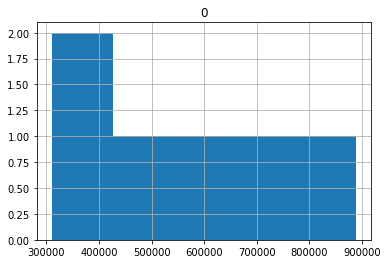

In [75]:
missing_values_per_column = azdias.isna().sum().sort_values(ascending=False)
# n = 60
n = 5
missing_values_per_column.iloc[0:n+1].to_frame().hist(bins=n)

In [80]:
sorted_columns[0:6]

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [81]:
# Scenario 1 where I remove only the 6 columns having more 34% missing data
azdias_col_minus6 = azdias.copy(deep=True)
for column in sorted_columns[0:6]:
    azdias_col_minus6.drop([column], axis=1, inplace=True)

In [83]:
azdias_col_minus6.shape

(891221, 79)

In [84]:
azdias_col_minus6.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [85]:
# Scenario 2 where I remove all the 46 columns having more 10% missing data
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
azdias_col_minus46 = azdias.copy(deep=True)
for column in sorted_columns[0:46]:
    azdias_col_minus46.drop([column], axis=1, inplace=True)


In [86]:
azdias_col_minus46.shape

(891221, 39)

In [87]:
azdias_col_minus46.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,WOHNDAUER_2008,KONSUMNAEHE,ONLINE_AFFINITAET
0,2.0,1.0,2.0,3.0,4.0,3.0,5.0,5.0,3.0,4.0,...,5.0,3.0,NaN,3.0,NaN,NaN,2.0,NaN,NaN,1.0
1,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,7.0,6.0,1.0,5.0,2.0,0.0,6.0,9.0,1.0,3.0
2,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,3.0,3.0,0.0,5.0,1.0,0.0,4.0,9.0,5.0,2.0
3,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,4.0,4.0,0.0,3.0,0.0,0.0,1.0,9.0,4.0,1.0
4,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,4.0,2.0,0.0,4.0,4.0,0.0,5.0,9.0,4.0,5.0


In [88]:
azdias.shape

(891221, 85)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of the 85 columns, 61 have missing data: TITEL_KZ, AGER_TYP have more than 70% missing data. While other columns like SOHO_KZ, ANZ_PERSONEN  have less than 10% missing data. 

I take 2 scenarii: 
- Scenario 1: I remove only the 6 columns having more than 34% missing data: 
['TITEL_KZ', 'AGER_TYP', 'KK_KUNDENTYP', 'KBA05_BAUMAX', 'GEBURTSJAHR', 'ALTER_HH']   
I copy the original dataset into a new dataframe called **azdias_col_minus6** where I remove these columns.

- Scenario 2: I remove all the 46 columns having more than 10% missing data. I copy the original dataset into a new dataframe called **azdias_col_minus46** where I remove these columns.

Are there any patterns in missing values? I didn't do this analysis, I didn't know how to use hist() to identify any patterns.

In [23]:
azdias_col.shape

(891221, 80)

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

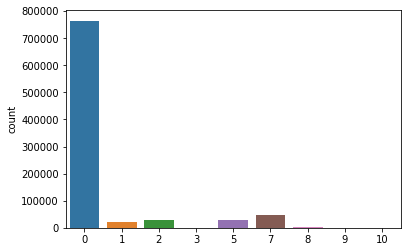

In [92]:
# How much data is missing in each row of the dataset azdias_col_minus46?
subset_col_minus46 = azdias_col_minus46.isna().sum(axis=1)
subset_col_minus46.mean()
subset_col_minus46.describe()
sorted(subset_col_minus46, reverse=True)
sns.countplot(subset_col_minus46);

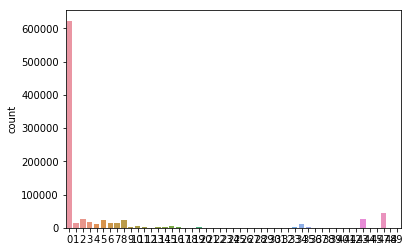

In [93]:
# How much data is missing in each row of the dataset azdias_112_2?
subset_col_minus6 = azdias_col_minus6.isna().sum(axis=1)
subset_col_minus6.mean()
subset_col_minus6.describe()
sorted(subset_col_minus6, reverse=True)
sns.countplot(subset_col_minus6);

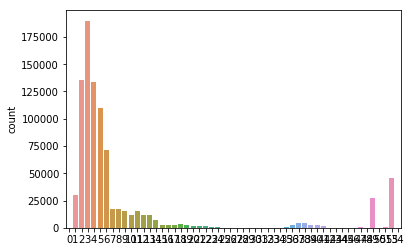

In [97]:
# How much data is missing in each row of the dataset azdias?
subset_all_cols = azdias.isna().sum(axis=1)
subset_all_cols.mean()
subset_all_cols.describe()
sorted(subset_all_cols, reverse=True)
sns.countplot(subset_all_cols);

In [114]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# On the azdias_col_minus6 dataframe where I removed 6 columns having more than 34% missing data, 
# based on the barchart above counting the #rows per number of missing values in each row, 
# I choose 0 as the threshold to separate the two subsets based on the number of missing values in each row

threshold = 0

subset_below = azdias_col_minus6.loc[azdias_col_minus6.isna().sum(axis=1) <= threshold]
print('subset_below.shape : ', subset_below.shape)

subset_above = azdias_col_minus6.loc[azdias_col_minus6.isna().sum(axis=1) > threshold]
print('subset_above.shape : ', subset_above.shape)



subset_below.shape :  (623209, 79)
subset_above.shape :  (268012, 79)


In [115]:
# Choose 5 columns where there are no missing values

# List all the columns having at least one NaN value
columns_without_NaN = []
for column in azdias:
    count_NaN = azdias[column].isna().sum()
    if count_NaN == 0:
        columns_without_NaN.append(column)

In [116]:
columns_without_NaN

['ANREDE_KZ',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_VORSORGER',
 'FINANZ_ANLEGER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_HAUSBAUER',
 'FINANZTYP',
 'GREEN_AVANTGARDE',
 'SEMIO_SOZ',
 'SEMIO_FAM',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [117]:
# azdias.groupby('ANZ_PERSONEN').count()
# azdias.groupby('KK_KUNDENTYP').count()
azdias['KK_KUNDENTYP'].isna().sum()

584612

I choose these 5 columns:
- ANREDE_KZ (Gender)
- FINANZTYP (Most descriptive financial type for individual)
- ZABEOTYP (Energy consumption typology)
- GREEN_AVANTGARDE (Membership in environmental sustainability as part of youth)
- SEMIO_MAT (Personality typology on dimension Materiality)


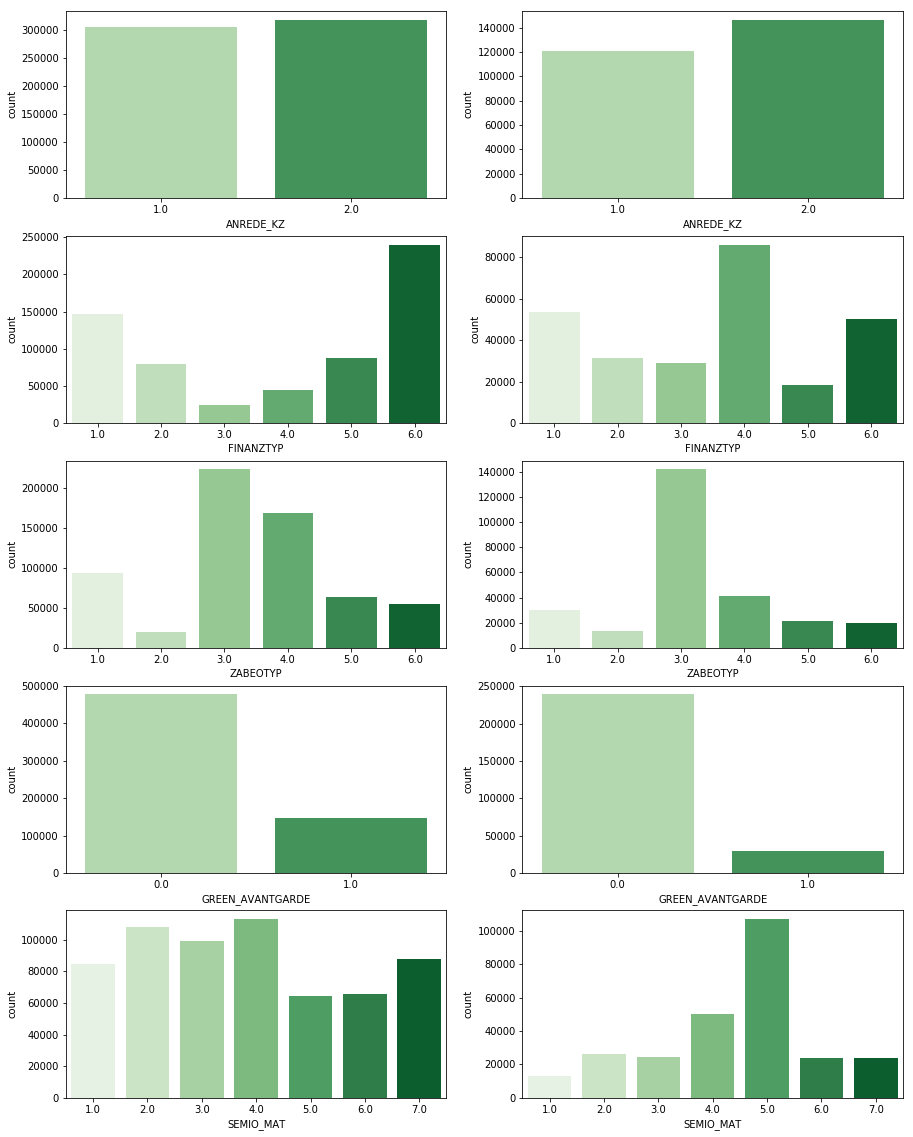

In [118]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
the_5_columns = ['ANREDE_KZ', 'FINANZTYP', 'ZABEOTYP', 'GREEN_AVANTGARDE', 'SEMIO_MAT']
fig, ax = plt.subplots(nrows = 5, ncols=2, figsize = [15,20])

i = 0
for c in the_5_columns: 
    sns.countplot(x=subset_below[c], ax = ax[i, 0], palette = 'Greens')
    sns.countplot(x=subset_above[c], ax = ax[i, 1], palette = 'Greens')
    i += 1

#### Discussion 1.1.3: Assess Missing Data in Each Row
Except for the FINANZTYP and SEMIO_MAT columns, the distribution of values of the dataset_below and the dataset_above are similar.

Per your guidance, I continue with the dataset subset_below, where the rows have no more than 0 missing values.


In [146]:
subset_below.shape

(623209, 79)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [121]:
# How many features are there of each data type?
feat_info.groupby(['type']).count()


,attribute,information_level,missing_or_unknown
type,,,
categorical,21,21,21
interval,1,1,1
mixed,7,7,7
numeric,7,7,7
ordinal,49,49,49


In the original dataset, there are:
- 21 variables of type 'categorical'
- 7 variables of type 'mixed'

In [122]:
categorical_variable = []
for c in subset_below:
    type = feat_info.loc[feat_info['attribute'] == c]['type']
    if type.item() == 'categorical':
        categorical_variable.append(c)

In [123]:
len(categorical_variable)

18

In [124]:
mixed_variable = []
for c in subset_below:
    type = feat_info.loc[feat_info['attribute'] == c]['type']
    if type.item() == 'mixed':
        mixed_variable.append(c)

In [125]:
mixed_variable

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In the subset_below, there are:
- 18 variables of type 'categorical'
- 6 variables of type 'mixed'

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [126]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_variable


['ANREDE_KZ',
 'CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'GREEN_AVANTGARDE',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'SOHO_KZ',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'OST_WEST_KZ',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [145]:
subset_below.groupby('OST_WEST_KZ').count()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
OST_WEST_KZ,,,,,,,,,,,,,,,,,,,,,
O,132330,132330,132330,132330,132330,132330,132330,132330,132330,132330,...,132330,132330,132330,132330,132330,132330,132330,132330,132330,132330
W,490879,490879,490879,490879,490879,490879,490879,490879,490879,490879,...,490879,490879,490879,490879,490879,490879,490879,490879,490879,490879


In [149]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Drop the 13 columns which are multi-level categoricals
subset2 = subset_below.drop(['CJT_GESAMTTYP',
                  'FINANZTYP', 
                  'GFK_URLAUBERTYP',
                  'LP_FAMILIE_FEIN',
                  'LP_FAMILIE_GROB',
                  'LP_STATUS_FEIN',
                  'LP_STATUS_GROB',
                  'NATIONALITAET_KZ',
                  'SHOPPER_TYP',
                  'ZABEOTYP',
                  'GEBAEUDETYP',
                  'CAMEO_DEUG_2015',
                  'CAMEO_DEU_2015'], axis=1)

In [151]:
subset2.shape

(623209, 66)

In [162]:
subset_below.shape

(623209, 79)

In [159]:
# In column 'OST_WEST_KZ': replace 'O' by 0 and 'W' by 1
subset2['OST_WEST_KZ'].replace('O', 0, inplace=True)
subset2['OST_WEST_KZ'].replace('W', 1, inplace=True)


In [163]:
subset2.groupby('OST_WEST_KZ').count()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
OST_WEST_KZ,,,,,,,,,,,,,,,,,,,,,
0,132330,132330,132330,132330,132330,132330,132330,132330,132330,132330,...,132330,132330,132330,132330,132330,132330,132330,132330,132330,132330
1,490879,490879,490879,490879,490879,490879,490879,490879,490879,490879,...,490879,490879,490879,490879,490879,490879,490879,490879,490879,490879


In [161]:
subset2.shape

(623209, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

Out of the 18 categorical variables:
- 13 are multi-level categoricals: I drop them from the analysis
- 4 are binary categoricals that take numeric values: I keep them as they are
- 1 ('OST_WEST_KZ' (Building location via former East / West Germany (GDR / FRG))) is binary that takes on non-numeric values: O and W, I re-encode it as 0 for East (Oast) and 1 or West.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [184]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
subset2.groupby('PRAEGENDE_JUGENDJAHRE').count()


,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
PRAEGENDE_JUGENDJAHRE,,,,,,,,,,,,,,,,,,,,,
1.0,15233,15233,15233,15233,15233,15233,15233,15233,15233,15233,...,15233,15233,15233,15233,15233,15233,15233,15233,15233,15233
2.0,6189,6189,6189,6189,6189,6189,6189,6189,6189,6189,...,6189,6189,6189,6189,6189,6189,6189,6189,6189,6189
3.0,44103,44103,44103,44103,44103,44103,44103,44103,44103,44103,...,44103,44103,44103,44103,44103,44103,44103,44103,44103,44103
4.0,18371,18371,18371,18371,18371,18371,18371,18371,18371,18371,...,18371,18371,18371,18371,18371,18371,18371,18371,18371,18371
5.0,69527,69527,69527,69527,69527,69527,69527,69527,69527,69527,...,69527,69527,69527,69527,69527,69527,69527,69527,69527,69527
6.0,22802,22802,22802,22802,22802,22802,22802,22802,22802,22802,...,22802,22802,22802,22802,22802,22802,22802,22802,22802,22802
7.0,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,...,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416
8.0,114745,114745,114745,114745,114745,114745,114745,114745,114745,114745,...,114745,114745,114745,114745,114745,114745,114745,114745,114745,114745
9.0,29033,29033,29033,29033,29033,29033,29033,29033,29033,29033,...,29033,29033,29033,29033,29033,29033,29033,29033,29033,29033


In [3]:
# function that I will use to create new interval-type variable 'DECADE': 
def parse_DECADE(x):
    if (x==1) | (x==2):
        return 40
    elif (x==3) | (x==4):
       return 50
    elif (x==5) | (x==6) | (x==7):
       return 60
    elif (x==8) | (x==9):
       return 70
    elif (x==10) | (x==11) | (x==12) | (x==13):
       return 80
    else:
       return 90


In [4]:
# function that I will use to create binary variable for movement (mainstream vs. avantgarde) 'MOVEMENT': 
# 1 for mainstream , 2 for avantgarde

def parse_MOVEMENT(x):
    if (x==1) | (x==3) | (x==5) | (x==8) | (x==10) | (x==12) | (x==14):
        return 1
    else:
        return 2

In [218]:
subset2['DECADE'] = subset2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: parse_DECADE(x))

In [220]:
subset2.groupby(['PRAEGENDE_JUGENDJAHRE', 'DECADE']).count()


,,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
PRAEGENDE_JUGENDJAHRE,DECADE,,,,,,,,,,,,,,,,,,,,,
1.0,40,15233,15233,15233,15233,15233,15233,15233,15233,15233,15233,...,15233,15233,15233,15233,15233,15233,15233,15233,15233,15233
2.0,40,6189,6189,6189,6189,6189,6189,6189,6189,6189,6189,...,6189,6189,6189,6189,6189,6189,6189,6189,6189,6189
3.0,50,44103,44103,44103,44103,44103,44103,44103,44103,44103,44103,...,44103,44103,44103,44103,44103,44103,44103,44103,44103,44103
4.0,50,18371,18371,18371,18371,18371,18371,18371,18371,18371,18371,...,18371,18371,18371,18371,18371,18371,18371,18371,18371,18371
5.0,60,69527,69527,69527,69527,69527,69527,69527,69527,69527,69527,...,69527,69527,69527,69527,69527,69527,69527,69527,69527,69527
6.0,60,22802,22802,22802,22802,22802,22802,22802,22802,22802,22802,...,22802,22802,22802,22802,22802,22802,22802,22802,22802,22802
7.0,60,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,...,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416
8.0,70,114745,114745,114745,114745,114745,114745,114745,114745,114745,114745,...,114745,114745,114745,114745,114745,114745,114745,114745,114745,114745
9.0,70,29033,29033,29033,29033,29033,29033,29033,29033,29033,29033,...,29033,29033,29033,29033,29033,29033,29033,29033,29033,29033


In [224]:
subset2['MOVEMENT'] = subset2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: parse_MOVEMENT(x))

In [225]:
subset2.groupby(['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']).count()


,,,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
PRAEGENDE_JUGENDJAHRE,DECADE,MOVEMENT,,,,,,,,,,,,,,,,,,,,,
1.0,40,1,15233,15233,15233,15233,15233,15233,15233,15233,15233,15233,...,15233,15233,15233,15233,15233,15233,15233,15233,15233,15233
2.0,40,2,6189,6189,6189,6189,6189,6189,6189,6189,6189,6189,...,6189,6189,6189,6189,6189,6189,6189,6189,6189,6189
3.0,50,1,44103,44103,44103,44103,44103,44103,44103,44103,44103,44103,...,44103,44103,44103,44103,44103,44103,44103,44103,44103,44103
4.0,50,2,18371,18371,18371,18371,18371,18371,18371,18371,18371,18371,...,18371,18371,18371,18371,18371,18371,18371,18371,18371,18371
5.0,60,1,69527,69527,69527,69527,69527,69527,69527,69527,69527,69527,...,69527,69527,69527,69527,69527,69527,69527,69527,69527,69527
6.0,60,2,22802,22802,22802,22802,22802,22802,22802,22802,22802,22802,...,22802,22802,22802,22802,22802,22802,22802,22802,22802,22802
7.0,60,2,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416,...,3416,3416,3416,3416,3416,3416,3416,3416,3416,3416
8.0,70,1,114745,114745,114745,114745,114745,114745,114745,114745,114745,114745,...,114745,114745,114745,114745,114745,114745,114745,114745,114745,114745
9.0,70,2,29033,29033,29033,29033,29033,29033,29033,29033,29033,29033,...,29033,29033,29033,29033,29033,29033,29033,29033,29033,29033


In [227]:
subset2.shape

(623209, 68)

In [165]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
subset2.groupby('CAMEO_INTL_2015').count()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
CAMEO_INTL_2015,,,,,,,,,,,,,,,,,,,,,
12,6900,6900,6900,6900,6900,6900,6900,6900,6900,6900,...,6900,6900,6900,6900,6900,6900,6900,6900,6900,6900
13,19617,19617,19617,19617,19617,19617,19617,19617,19617,19617,...,19617,19617,19617,19617,19617,19617,19617,19617,19617,19617
14,48465,48465,48465,48465,48465,48465,48465,48465,48465,48465,...,48465,48465,48465,48465,48465,48465,48465,48465,48465,48465
15,13578,13578,13578,13578,13578,13578,13578,13578,13578,13578,...,13578,13578,13578,13578,13578,13578,13578,13578,13578,13578
22,23899,23899,23899,23899,23899,23899,23899,23899,23899,23899,...,23899,23899,23899,23899,23899,23899,23899,23899,23899,23899
23,14693,14693,14693,14693,14693,14693,14693,14693,14693,14693,...,14693,14693,14693,14693,14693,14693,14693,14693,14693,14693
24,73984,73984,73984,73984,73984,73984,73984,73984,73984,73984,...,73984,73984,73984,73984,73984,73984,73984,73984,73984,73984
25,30969,30969,30969,30969,30969,30969,30969,30969,30969,30969,...,30969,30969,30969,30969,30969,30969,30969,30969,30969,30969
31,12370,12370,12370,12370,12370,12370,12370,12370,12370,12370,...,12370,12370,12370,12370,12370,12370,12370,12370,12370,12370


In [239]:
subset2['WEALTH'] = subset2['CAMEO_INTL_2015'].apply(lambda x: (int(x) % 100) // 10)

In [241]:
subset2['LIFE_STAGE'] = subset2['CAMEO_INTL_2015'].apply(lambda x: (int(x) % 10))

In [242]:
subset2.groupby(['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']).count()

,,,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT
CAMEO_INTL_2015,WEALTH,LIFE_STAGE,,,,,,,,,,,,,,,,,,,,,
12,1,2,6900,6900,6900,6900,6900,6900,6900,6900,6900,6900,...,6900,6900,6900,6900,6900,6900,6900,6900,6900,6900
13,1,3,19617,19617,19617,19617,19617,19617,19617,19617,19617,19617,...,19617,19617,19617,19617,19617,19617,19617,19617,19617,19617
14,1,4,48465,48465,48465,48465,48465,48465,48465,48465,48465,48465,...,48465,48465,48465,48465,48465,48465,48465,48465,48465,48465
15,1,5,13578,13578,13578,13578,13578,13578,13578,13578,13578,13578,...,13578,13578,13578,13578,13578,13578,13578,13578,13578,13578
22,2,2,23899,23899,23899,23899,23899,23899,23899,23899,23899,23899,...,23899,23899,23899,23899,23899,23899,23899,23899,23899,23899
23,2,3,14693,14693,14693,14693,14693,14693,14693,14693,14693,14693,...,14693,14693,14693,14693,14693,14693,14693,14693,14693,14693
24,2,4,73984,73984,73984,73984,73984,73984,73984,73984,73984,73984,...,73984,73984,73984,73984,73984,73984,73984,73984,73984,73984
25,2,5,30969,30969,30969,30969,30969,30969,30969,30969,30969,30969,...,30969,30969,30969,30969,30969,30969,30969,30969,30969,30969
31,3,1,12370,12370,12370,12370,12370,12370,12370,12370,12370,12370,...,12370,12370,12370,12370,12370,12370,12370,12370,12370,12370


In [247]:
subset2.shape

(623209, 70)

In [244]:
# Have a look at the other mixed variables
# Decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section
mixed_variable

['LP_LEBENSPHASE_FEIN',
 'LP_LEBENSPHASE_GROB',
 'PRAEGENDE_JUGENDJAHRE',
 'WOHNLAGE',
 'CAMEO_INTL_2015',
 'PLZ8_BAUMAX']

In [248]:
# For simplicity, I decide to drop all the other mixed variables
subset3 = subset2.drop(['LP_LEBENSPHASE_FEIN',
                        'LP_LEBENSPHASE_GROB',
                        'PRAEGENDE_JUGENDJAHRE',
                        'WOHNLAGE',
                        'CAMEO_INTL_2015',
                        'PLZ8_BAUMAX'], axis=1)

In [249]:
subset3.shape

(623209, 64)

In [254]:
subset3.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,90,1,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,90,2,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0.0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,70,1,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0.0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,50,1,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0.0,2.0,...,0.0,5.0,5.0,4.0,6.0,3.0,80,1,2,2


#### Discussion 1.2.2: Engineer Mixed-Type Features

I created DECADE and MOVEMENT from the PRAEGENDE_JUGENDJAHRE mixed variable ; and I dropped PRAEGENDE_JUGENDJAHRE.

I created WEALTH and LIFE_STAGE from the CAMEO_INTL_2015 mixed variable ; and I dropped CAMEO_INTL_2015.

I dropped the other mixed variables

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [253]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

# sorted(subset3.isna().sum(), reverse=True)

# DONE: no missing data in subset3


In [ ]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

# DONE

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [5]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # IDENTIFY MISSING OR UNKNOWN DATA VALUES AND CONVERT THEM TO NaNs
    features_with_missing_or_unknown = {}
    for column in df:
        # missing or unknown values listed in feat_info.missing_or_unknown for feat_info.attribute = column
        missing_or_unknown_values = feat_info[feat_info.attribute == column].missing_or_unknown.values[0]
        missing_or_unknown_values = missing_or_unknown_values.replace('[','')
        missing_or_unknown_values = missing_or_unknown_values.replace(']','')
        list_missing_or_unknown_values = missing_or_unknown_values.split(',')
    
        # replace the missing or unknown values by NaN
        df.loc[df[column].isin(list_missing_or_unknown_values), column] = np.nan
    
    # REMOVE SELECTED COLUMNS
    # List all the columns having at least one NaN value
    count_NaN_by_column = {}
    for column in azdias:
        count_NaN = df[column].isna().sum()
        if count_NaN > 0:
            count_NaN_by_column[column] = count_NaN  

    # Sort the columns: on top the ones which have the highest occurence of NaN
    sorted_columns = sorted(count_NaN_by_column, 
                            key=count_NaN_by_column.get, 
                            reverse=True)

    # Scenario 1 where I remove only the 6 columns having more 34% (on general population demographics data) of missing data
    df_col_minus_scenario1 = df.copy(deep=True)
    for column in sorted_columns[0:6]:
        df_col_minus_scenario1.drop([column], axis=1, inplace=True)
    
    # Scenario 2 where I remove the 46 columns having more 10% (on general population demographics data) of missing data
    df_col_minus_scenario2 = df.copy(deep=True)
    for column in sorted_columns[0:46]:
        df_col_minus_scenario2.drop([column], axis=1, inplace=True)
    
    # FOLLOWING SCENARIO 1: REMOVE ROWS HAVING AT LEAST ONE MISSING VALUE
    threshold = 0
    subset_below = df_col_minus_scenario1.loc[df_col_minus_scenario1.isna().sum(axis=1) <= threshold]

    # SELECT, RE-ENCODE, AND ENGINEER COLUMN VALUES
    # Drop the 13 columns which are multi-level categoricals
    subset2 = subset_below.drop(['CJT_GESAMTTYP',
                      'FINANZTYP', 
                      'GFK_URLAUBERTYP',
                      'LP_FAMILIE_FEIN',
                      'LP_FAMILIE_GROB',
                      'LP_STATUS_FEIN',
                      'LP_STATUS_GROB',
                      'NATIONALITAET_KZ',
                      'SHOPPER_TYP',
                      'ZABEOTYP',
                      'GEBAEUDETYP',
                      'CAMEO_DEUG_2015',
                      'CAMEO_DEU_2015'], axis=1)
    
    # In column 'OST_WEST_KZ': replace 'O' by 0 and 'W' by 1
    subset2['OST_WEST_KZ'].replace('O', 0, inplace=True)
    subset2['OST_WEST_KZ'].replace('W', 1, inplace=True)
    
    # Engineer two new variables out of each of the mixed variables 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'
    subset2['DECADE'] = subset2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: parse_DECADE(x))
    subset2['MOVEMENT'] = subset2['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: parse_MOVEMENT(x))
    subset2['WEALTH'] = subset2['CAMEO_INTL_2015'].apply(lambda x: (int(x) % 100) // 10)
    subset2['LIFE_STAGE'] = subset2['CAMEO_INTL_2015'].apply(lambda x: (int(x) % 10))
    
    # For simplicity, I decide to drop all the other mixed variables
    subset3 = subset2.drop(['LP_LEBENSPHASE_FEIN',
                            'LP_LEBENSPHASE_GROB',
                            'PRAEGENDE_JUGENDJAHRE',
                            'WOHNLAGE',
                            'CAMEO_INTL_2015',
                            'PLZ8_BAUMAX'], axis=1)
    
    # Return the cleaned dataframe.
    return(subset3)
    
    

In [6]:
clean_azdias = clean_data(azdias)

In [7]:
clean_azdias.shape

(623209, 64)

In [8]:
# Load in the customers data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')

In [10]:
clean_customers = clean_data(customers)

In [11]:
clean_customers.shape

(115643, 64)

In [9]:
customers.shape

(191652, 85)

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [8]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# Check again that there is no NaN values in the cleaned dataset
clean_azdias.isna().sum().sum()

0

In [9]:
# Apply feature scaling to the general population demographics data.
from sklearn import preprocessing as p

clean_azdias_ss = p.StandardScaler().fit_transform(clean_azdias) # Fit and transform the data

In [10]:
clean_azdias_ss = pd.DataFrame(clean_azdias_ss) #create a dataframe

In [11]:
clean_azdias_ss.shape

(623209, 64)

In [15]:
clean_azdias_ss.describe()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
count,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,...,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05,6.232090e+05
mean,9.230537e-17,-2.158277e-17,1.261674e-16,1.374262e-16,1.478300e-16,3.104019e-18,7.332212e-17,1.068934e-16,8.841751e-18,-2.007779e-16,...,-3.188674e-17,-1.859732e-16,-1.265550e-18,-6.449747e-17,-3.937743e-17,-3.672377e-17,-3.722087e-16,-1.550955e-16,1.881224e-18,-3.490953e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746291e+00,-1.022678e+00,-1.512224e+00,-1.141401e+00,-1.765051e+00,-1.221857e+00,-1.139028e+00,-1.588887e+00,-5.536702e-01,-1.591638e+00,...,-9.819733e-01,-2.721004e+00,-2.111167e+00,-2.223028e+00,-1.914219e+00,-1.563996e+00,-2.280180e+00,-5.536702e-01,-1.595957e+00,-1.251108e+00
25%,-7.720918e-01,-1.022678e+00,-7.773472e-01,-1.141401e+00,-1.045042e+00,-1.221857e+00,-1.139028e+00,-8.565448e-01,-5.536702e-01,-2.734958e-01,...,-9.819733e-01,-6.397021e-01,-3.147638e-01,-2.011809e-01,-6.074385e-01,-8.238438e-01,-9.023264e-01,-5.536702e-01,-9.099974e-01,-1.251108e+00
50%,2.021075e-01,9.778248e-01,-4.247059e-02,2.198282e-01,3.949756e-01,1.586008e-01,-4.103275e-01,-1.242026e-01,-5.536702e-01,-2.734958e-01,...,3.846698e-01,-6.397021e-01,-3.147638e-01,-2.011809e-01,-1.718451e-01,-8.369115e-02,-2.133995e-01,-5.536702e-01,4.619220e-01,8.284537e-02
75%,1.176307e+00,9.778248e-01,6.924060e-01,9.004431e-01,1.114984e+00,8.488295e-01,1.047073e+00,6.081396e-01,-5.536702e-01,1.044647e+00,...,3.846698e-01,4.009487e-01,5.834378e-01,8.097426e-01,6.993416e-01,6.564615e-01,1.164454e+00,-5.536702e-01,1.147882e+00,7.498218e-01
max,1.176307e+00,9.778248e-01,1.427283e+00,1.581058e+00,1.114984e+00,1.539058e+00,1.775773e+00,1.340482e+00,1.806129e+00,1.044647e+00,...,1.751313e+00,1.441599e+00,1.481640e+00,1.820666e+00,1.570528e+00,1.396614e+00,1.164454e+00,1.806129e+00,1.147882e+00,1.416798e+00


In [16]:
clean_azdias_ss.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,0.384670,1.441599,0.583438,-0.201181,-0.171845,0.656462,1.164454,-0.553670,1.147882,-1.251108
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.981973,0.400949,0.583438,-0.201181,-0.171845,-0.823844,1.164454,1.806129,-0.909997,0.749822
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,0.384670,-0.639702,-0.314764,0.809743,0.263748,1.396614,-0.213400,-0.553670,0.461922,0.082845
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,0.384670,1.441599,1.481640,-1.212105,-1.043032,-0.083691,-1.591253,-0.553670,1.147882,0.749822
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.981973,1.441599,1.481640,0.809743,0.263748,-0.083691,0.475527,-0.553670,-0.909997,-0.584131


In [12]:
clean_azdias_ss.columns = clean_azdias.columns

In [13]:
clean_azdias_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-1.746291,0.977825,-1.512224,1.581058,-1.045042,1.539058,1.047073,1.340482,-0.553670,1.044647,...,0.384670,1.441599,0.583438,-0.201181,-0.171845,0.656462,1.164454,-0.553670,1.147882,-1.251108
1,0.202107,0.977825,-1.512224,0.900443,-1.765051,-0.531628,0.318373,1.340482,1.806129,1.044647,...,-0.981973,0.400949,0.583438,-0.201181,-0.171845,-0.823844,1.164454,1.806129,-0.909997,0.749822
2,0.202107,-1.022678,0.692406,0.219828,0.394976,-1.221857,0.318373,-0.856545,-0.553670,1.044647,...,0.384670,-0.639702,-0.314764,0.809743,0.263748,1.396614,-0.213400,-0.553670,0.461922,0.082845
3,-1.746291,0.977825,-0.042471,-1.141401,1.114984,-0.531628,-0.410328,1.340482,-0.553670,1.044647,...,0.384670,1.441599,1.481640,-1.212105,-1.043032,-0.083691,-1.591253,-0.553670,1.147882,0.749822
4,-0.772092,0.977825,-1.512224,1.581058,-1.765051,1.539058,1.047073,-0.124203,-0.553670,-0.273496,...,-0.981973,1.441599,1.481640,0.809743,0.263748,-0.083691,0.475527,-0.553670,-0.909997,-0.584131


### Discussion 2.1: Apply Feature Scaling

As recommended I checked that the cleaned dataset has no NaN values and I applied the StandardScaler scaling function. 
I checked that the scaled dataframe has for each its feature a mean = 0 and a standard deviation = 1.
I renamed the headers like the headers of the original dataframe.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [14]:
# Apply PCA to the data.
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [43]:
n_components = 40
pca = PCA(n_components)
clean_azdias_ss_pca = pca.fit_transform(clean_azdias_ss)

In [38]:
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

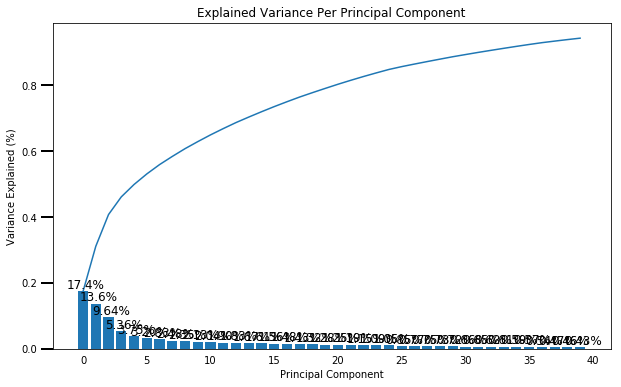

In [45]:
# Investigate the variance accounted for by each principal component.
scree_plot(pca)

In [59]:
def pca_results(full_dataset, pca):
	'''
	Create a DataFrame of the PCA results
	Includes dimension feature weights and explained variance
	Visualizes the PCA results
	'''

	# Dimension indexing
	dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

	# PCA components
	components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
	components.index = dimensions

	# PCA explained variance
	ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
	variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
	variance_ratios.index = dimensions

	# Create a bar plot visualization
	# fig, ax = plt.subplots(figsize = (14,8))

	# Plot the feature weights as a function of the components
	# components.plot(ax = ax, kind = 'bar');
	# ax.set_ylabel("Feature Weights")
	# ax.set_xticklabels(dimensions, rotation=0)

	# Display the explained variance ratios
	# for i, ev in enumerate(pca.explained_variance_ratio_):
	# 	ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

	# Return a concatenated DataFrame
	return pd.concat([variance_ratios, components], axis = 1)

Using 21 components, we can explain 0.8027000000000002% of the variability in the original data.


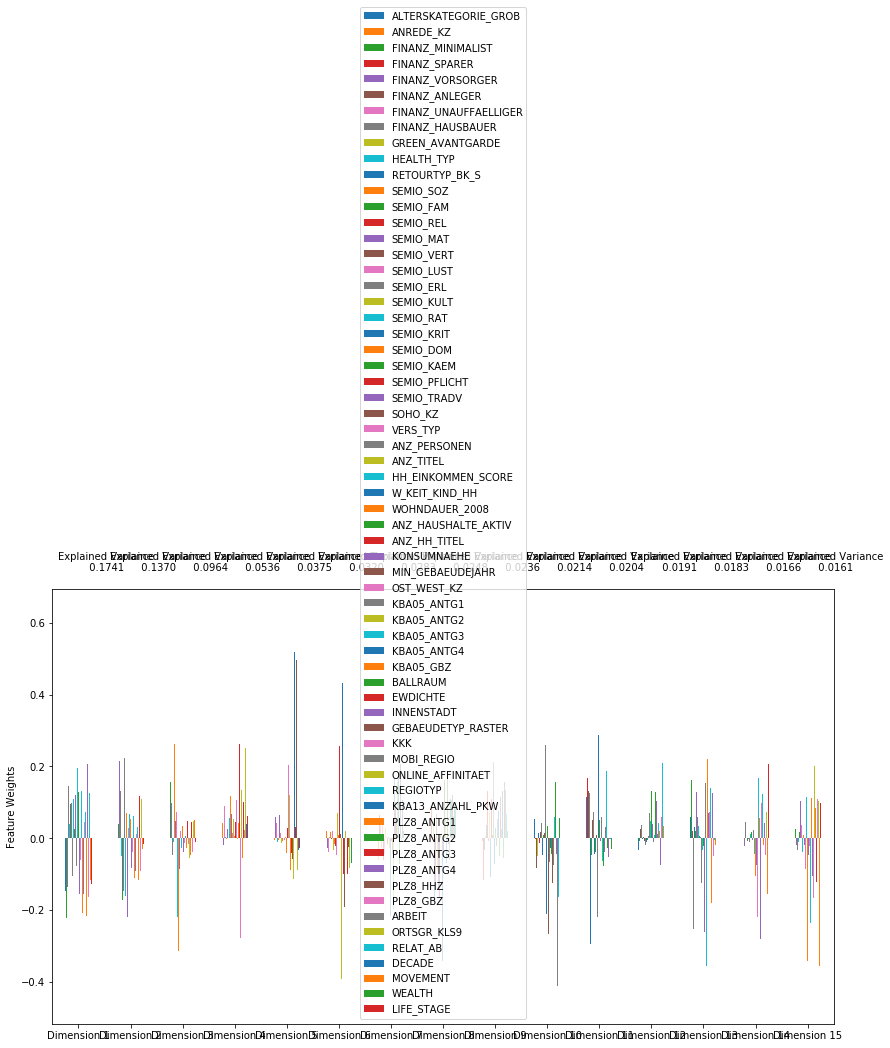

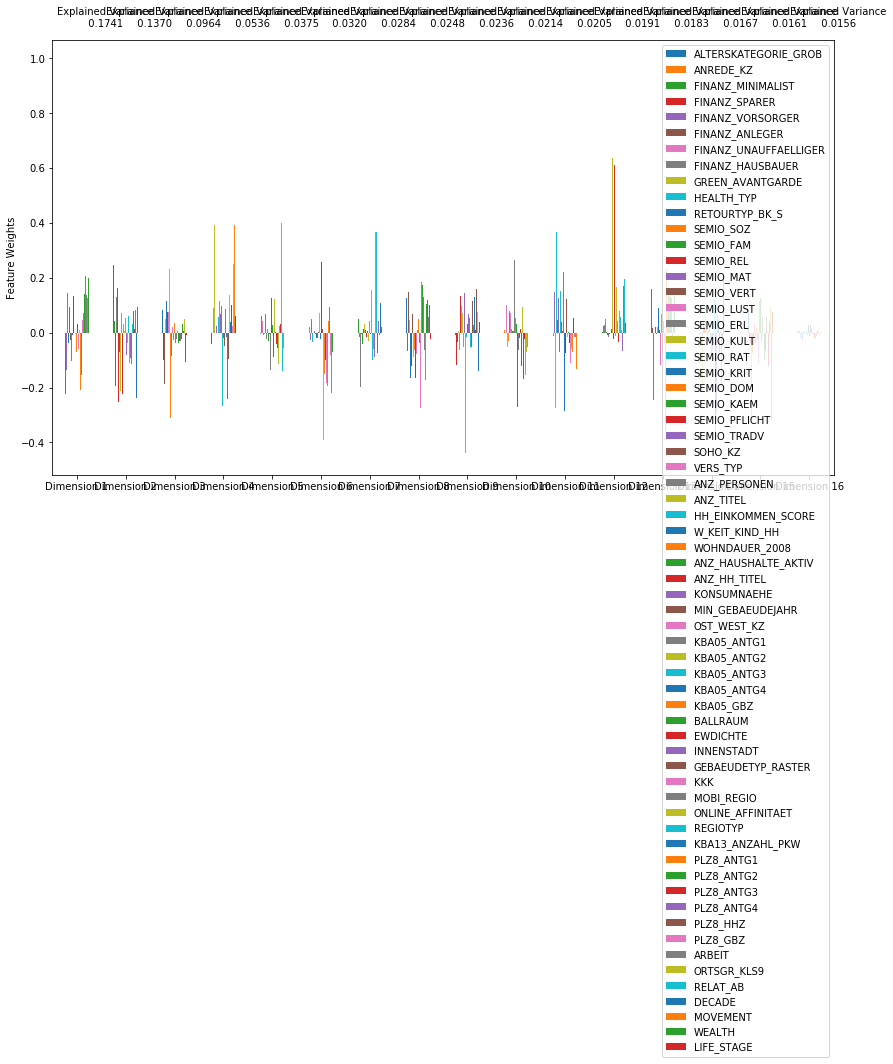

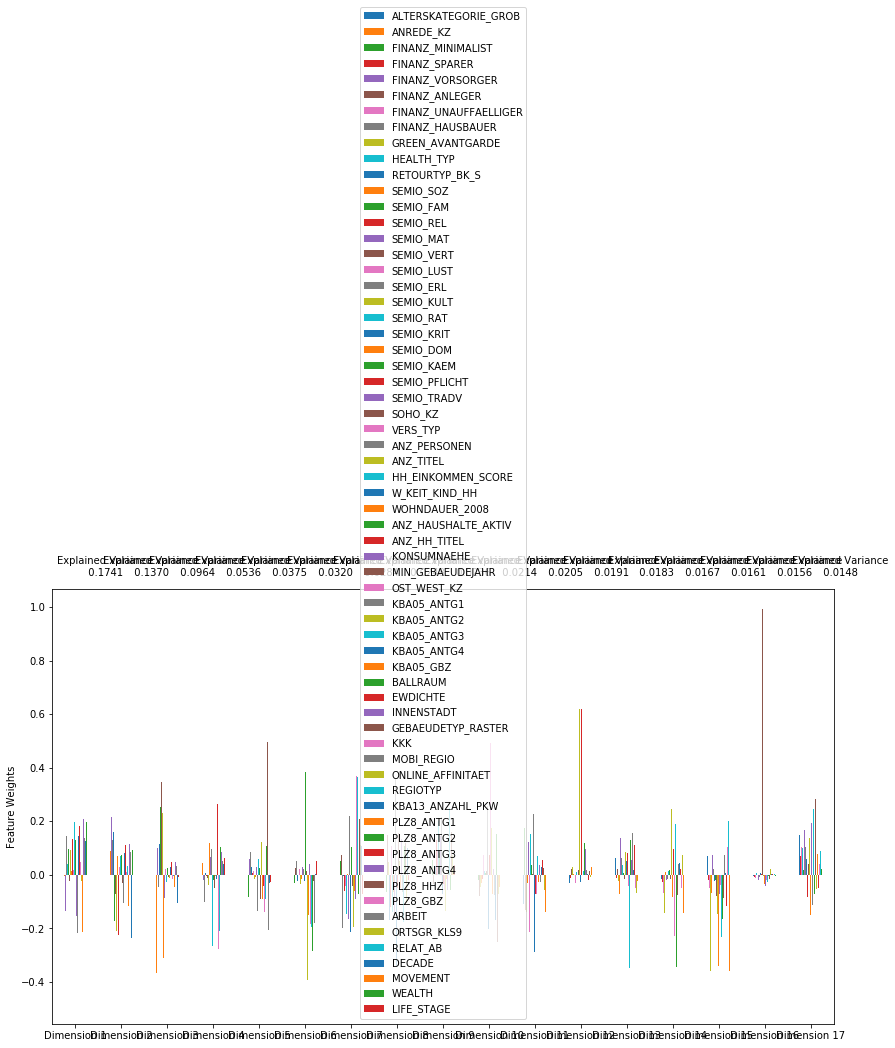

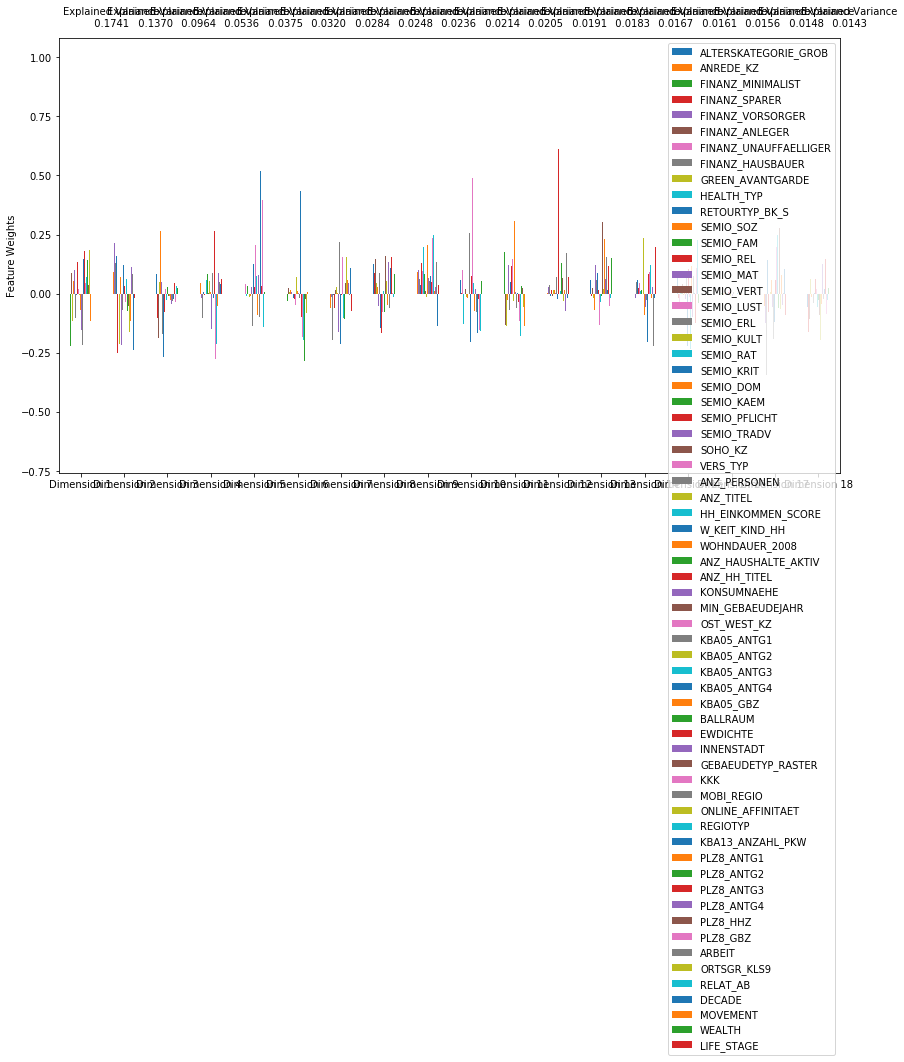

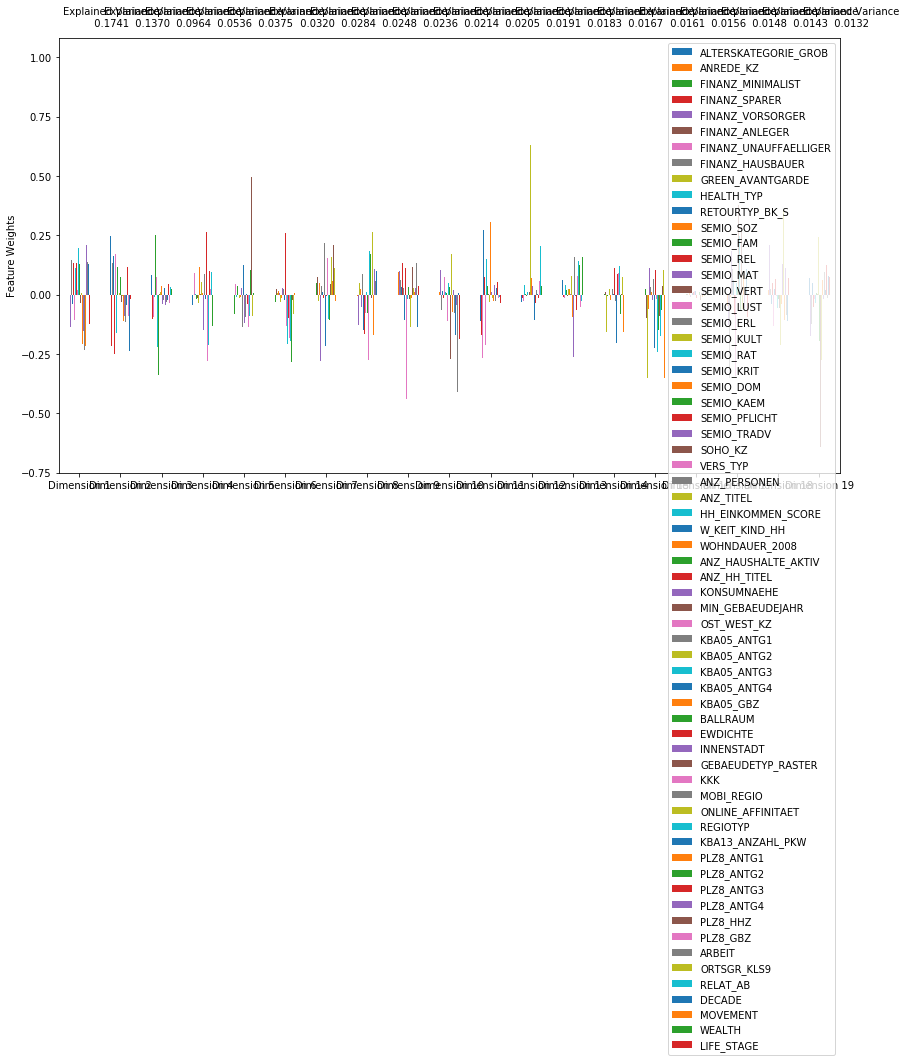

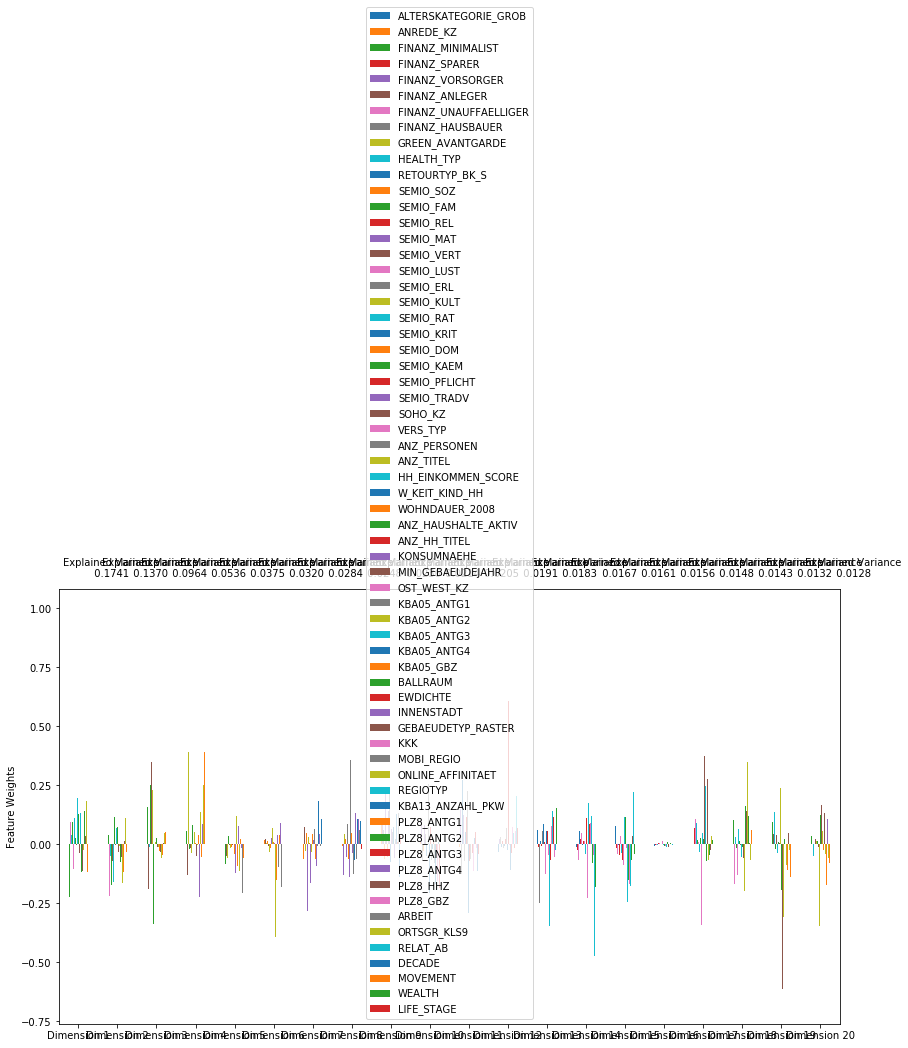

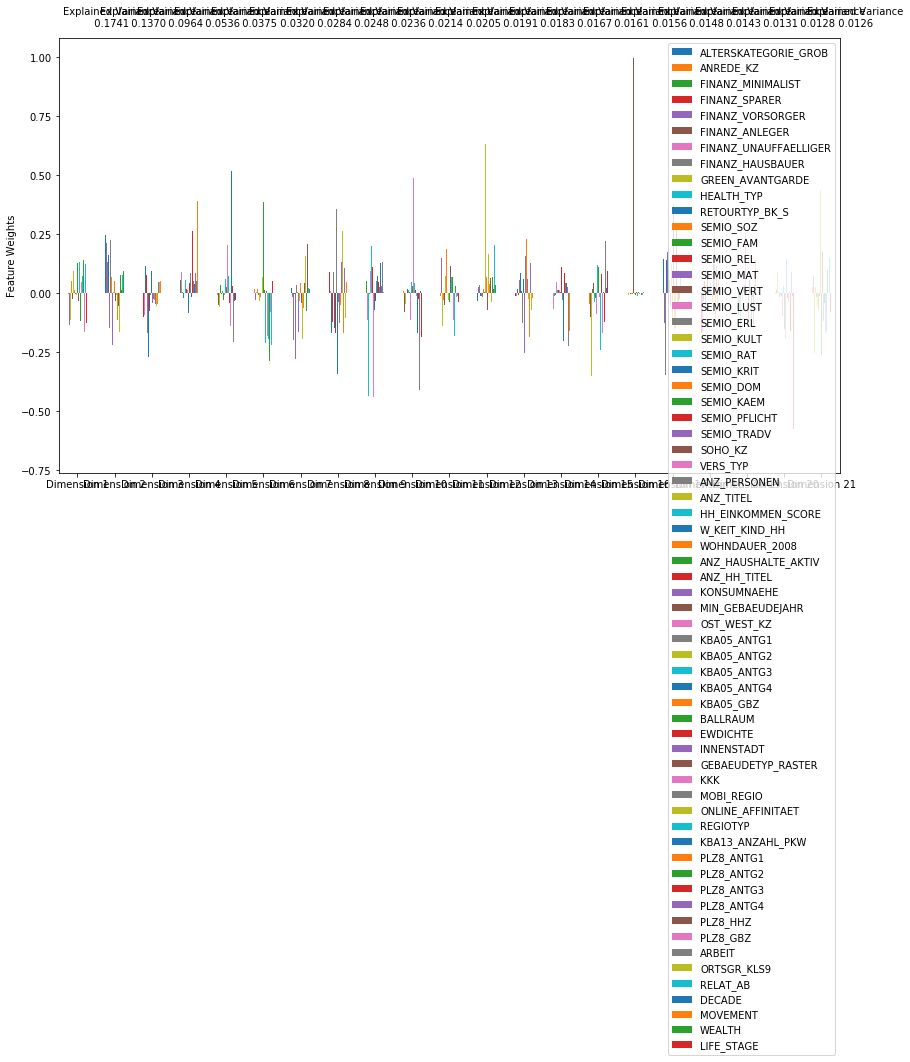

In [58]:
# Code to find number of components providing more than 
# 80% of variance explained
for comp in range(15, clean_azdias_ss.shape[1]):
    pca = PCA(comp)
    clean_azdias_ss_pca = pca.fit_transform(clean_azdias_ss)
    comp_check = pca_results(clean_azdias_ss, pca)
    if comp_check['Explained Variance'].sum() > 0.8:
        break
        
num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))
   

In [15]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 21
pca = PCA(n_components)
clean_azdias_ss_pca = pca.fit_transform(clean_azdias_ss)


### Discussion 2.2: Perform Dimensionality Reduction

I applied the principal component analysis on the scaled dataset, using 40 components (more than half of the number of features).
I plotted the explained variance per principal component, using the scree_plot function that I found in the helper_functions notebook of the class. Based on the graph, I see that 80% of the variability in the original sacled dataset may be explained using between 15 and 25 components.
I then used a loop to find the minimum number of components that provide more than 80% of variance explained. I used the pca_results function that I found in the help_functions notebook too.

Conclusion: 80% of the variability in the original scales data can be explained using just 21 components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [61]:
len(pca.components_)

21

In [64]:
components = pd.DataFrame(np.round(pca.components_, 4), columns = clean_azdias_ss.keys())

In [65]:
components.index = dimensions

In [122]:
components

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
Dimension 1,-0.1479,-0.0039,-0.2225,0.1658,-0.1364,0.0873,0.0947,0.1449,-0.1153,0.0386,...,0.2076,0.0356,-0.1627,0.1372,0.1842,0.1250,0.1267,-0.1153,0.1972,-0.1260
Dimension 2,0.2452,0.0902,0.0408,-0.2174,0.2138,-0.1935,-0.2169,0.1309,-0.0309,-0.0489,...,0.1129,0.0149,-0.0924,0.0832,0.1106,0.0778,-0.2368,-0.0309,0.0927,-0.0171
Dimension 3,0.0824,-0.3676,0.1567,-0.1013,0.0982,-0.1883,-0.0928,-0.0474,0.0508,-0.0108,...,0.0464,0.0066,-0.0375,0.0330,0.0488,0.0314,-0.1076,0.0508,0.0249,-0.0093
Dimension 4,-0.0423,0.0428,0.0583,-0.0004,-0.0199,-0.1284,0.0888,-0.1018,0.3916,0.0034,...,0.0856,0.1292,0.0228,0.0510,0.2503,0.0934,0.0408,0.3916,-0.1308,0.0612
Dimension 5,-0.0023,-0.0062,-0.0833,-0.0001,0.0597,-0.0489,0.0428,0.0862,-0.0577,-0.0093,...,-0.0156,0.4956,0.3978,-0.2066,-0.0893,-0.1395,-0.0323,-0.0577,0.0078,-0.0272
Dimension 6,-0.0051,0.0201,-0.0323,0.0033,-0.0277,0.0251,-0.0393,0.0504,0.0049,-0.0354,...,0.0914,-0.0250,-0.0808,-0.1800,-0.0821,-0.2194,0.0010,0.0049,-0.0700,0.0501
Dimension 7,0.0222,-0.0605,0.0494,0.0654,-0.0158,0.0749,0.0521,-0.1975,-0.0275,0.2375,...,0.0430,0.2077,0.1234,-0.0062,0.1101,0.0219,0.1070,-0.0275,0.0199,-0.0725
Dimension 8,0.1267,-0.0076,-0.0661,0.0886,-0.1284,0.1479,0.0092,0.0503,0.0461,-0.1231,...,0.1071,0.1197,0.0005,0.0594,-0.1052,-0.0137,0.1015,0.0461,0.0821,-0.0210
Dimension 9,-0.0066,0.0931,0.0539,-0.1172,0.0985,-0.0332,-0.1151,0.0617,0.0071,-0.4352,...,0.0293,0.1576,0.0915,0.1346,0.0738,0.0675,-0.1387,0.0071,0.0211,0.0348
Dimension 10,0.0570,0.0086,-0.0205,0.0012,0.1041,-0.0810,0.0995,-0.0662,-0.0468,-0.1285,...,-0.0417,-0.2524,-0.1562,-0.4109,-0.0717,-0.1594,0.0087,-0.0468,0.0534,-0.1854


In [120]:
# sorted(components.iloc[0])
components.iloc[0]

ALTERSKATEGORIE_GROB    -0.1479
ANREDE_KZ               -0.0039
FINANZ_MINIMALIST       -0.2225
FINANZ_SPARER            0.1658
FINANZ_VORSORGER        -0.1364
FINANZ_ANLEGER           0.0873
FINANZ_UNAUFFAELLIGER    0.0947
FINANZ_HAUSBAUER         0.1449
GREEN_AVANTGARDE        -0.1153
HEALTH_TYP               0.0386
RETOURTYP_BK_S          -0.0385
SEMIO_SOZ                0.0527
SEMIO_FAM                0.0946
SEMIO_REL                0.1316
SEMIO_MAT                0.0978
SEMIO_VERT              -0.0252
SEMIO_LUST              -0.1060
SEMIO_ERL               -0.1052
SEMIO_KULT               0.0928
SEMIO_RAT                0.1102
SEMIO_KRIT              -0.0074
SEMIO_DOM                0.0133
SEMIO_KAEM               0.0269
SEMIO_PFLICHT            0.1342
SEMIO_TRADV              0.1203
SOHO_KZ                 -0.0021
VERS_TYP                 0.0185
ANZ_PERSONEN            -0.0770
ANZ_TITEL               -0.0059
HH_EINKOMMEN_SCORE       0.1951
                          ...  
KONSUMNA

In [121]:
df = components.iloc[0]
df.iloc[(-np.abs(df.values)).argsort()]

MOBI_REGIO              -0.2331
FINANZ_MINIMALIST       -0.2225
KBA05_ANTG1             -0.2184
PLZ8_ANTG1              -0.2154
PLZ8_ANTG3               0.2137
KBA05_GBZ               -0.2081
PLZ8_ANTG4               0.2076
WEALTH                   0.1972
HH_EINKOMMEN_SCORE       0.1951
ORTSGR_KLS9              0.1842
EWDICHTE                 0.1812
FINANZ_SPARER            0.1658
PLZ8_GBZ                -0.1627
KONSUMNAEHE             -0.1561
INNENSTADT              -0.1542
ALTERSKATEGORIE_GROB    -0.1479
KBA05_ANTG4              0.1463
FINANZ_HAUSBAUER         0.1449
PLZ8_ANTG2               0.1416
ARBEIT                   0.1372
FINANZ_VORSORGER        -0.1364
SEMIO_PFLICHT            0.1342
SEMIO_REL                0.1316
KBA05_ANTG3              0.1315
ANZ_HAUSHALTE_AKTIV      0.1301
DECADE                   0.1267
LIFE_STAGE              -0.1260
RELAT_AB                 0.1250
SEMIO_TRADV              0.1203
BALLRAUM                -0.1170
                          ...  
SEMIO_LU

In [66]:
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)

In [67]:
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])

In [69]:
variance_ratios.index = dimensions

In [72]:
variance_ratios.head()

,Explained Variance
Dimension 1,0.1741
Dimension 2,0.1370
Dimension 3,0.0964
Dimension 4,0.0536
Dimension 5,0.0375


In [17]:
pca.explained_variance_ratio_

array([ 0.17412295,  0.13698058,  0.0964338 ,  0.05361775,  0.03754851,
        0.03201816,  0.02835135,  0.02482454,  0.02358918,  0.0213909 ,
        0.02046456,  0.01908535,  0.01829969,  0.01670446,  0.01613754,
        0.01561791,  0.01482123,  0.01433811,  0.01321953,  0.01285038,
        0.01259193])

In [77]:
pca.explained_variance_ratio_[:3]

array([ 0.17412295,  0.13698058,  0.0964338 ])

In [16]:
# Function to map weights for the first i-th principal component to corresponding feature names
# and then print the linked values, sorted by weight.

def pca_results_by_component(full_dataset, pca, i_th_component):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Print the features, sorted by absolute weight, of the i_th_component
    '''
    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
    
    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions
    
    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions
    
    # Print the variance explained by the i_th component
    print('Variance explained by the component #{}: {}'.format(
        i_th_component, 
        round(pca.explained_variance_ratio_[i_th_component], 4)))
    
    # Print the features sorted by absolute weight of the i_th_component
    df = components.iloc[i_th_component]
    sorted_features_i_th_component = df.iloc[(-np.abs(df.values)).argsort()]
    print('List of the corresponding features sorted by their absolute weight: ')
    print(sorted_features_i_th_component)
    
    # Return a concatenated DataFrame
    # return pd.concat([variance_ratios, components], axis = 1)


In [18]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results_by_component(clean_azdias_ss, pca,0)

Variance explained by the component #0: 0.1741
List of the corresponding features sorted by their absolute weight: 
MOBI_REGIO              -0.2331
FINANZ_MINIMALIST       -0.2225
KBA05_ANTG1             -0.2184
PLZ8_ANTG1              -0.2154
PLZ8_ANTG3               0.2137
KBA05_GBZ               -0.2081
PLZ8_ANTG4               0.2076
WEALTH                   0.1972
HH_EINKOMMEN_SCORE       0.1951
ORTSGR_KLS9              0.1842
EWDICHTE                 0.1812
FINANZ_SPARER            0.1658
PLZ8_GBZ                -0.1627
KONSUMNAEHE             -0.1561
INNENSTADT              -0.1542
ALTERSKATEGORIE_GROB    -0.1479
KBA05_ANTG4              0.1463
FINANZ_HAUSBAUER         0.1449
PLZ8_ANTG2               0.1416
ARBEIT                   0.1372
FINANZ_VORSORGER        -0.1364
SEMIO_PFLICHT            0.1342
SEMIO_REL                0.1316
KBA05_ANTG3              0.1315
ANZ_HAUSHALTE_AKTIV      0.1301
DECADE                   0.1267
LIFE_STAGE              -0.1260
RELAT_AB            

In [19]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results_by_component(clean_azdias_ss, pca, 1)

Variance explained by the component #1: 0.137
List of the corresponding features sorted by their absolute weight: 
SEMIO_REL               -0.2515
ALTERSKATEGORIE_GROB     0.2452
DECADE                  -0.2368
SEMIO_PFLICHT           -0.2250
SEMIO_ERL                0.2243
SEMIO_TRADV             -0.2184
FINANZ_SPARER           -0.2174
FINANZ_UNAUFFAELLIGER   -0.2169
FINANZ_VORSORGER         0.2138
SEMIO_KULT              -0.2121
FINANZ_ANLEGER          -0.1935
SEMIO_FAM               -0.1722
SEMIO_LUST               0.1691
ONLINE_AFFINITAET       -0.1629
RETOURTYP_BK_S           0.1611
SEMIO_RAT               -0.1606
SEMIO_MAT               -0.1462
FINANZ_HAUSBAUER         0.1309
SEMIO_KRIT               0.1221
W_KEIT_KIND_HH           0.1199
PLZ8_ANTG3               0.1178
PLZ8_ANTG1              -0.1165
SEMIO_KAEM               0.1154
MOBI_REGIO              -0.1148
PLZ8_ANTG4               0.1129
KBA05_GBZ               -0.1112
EWDICHTE                 0.1108
ORTSGR_KLS9          

In [20]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results_by_component(clean_azdias_ss, pca, 2)

Variance explained by the component #2: 0.0964
List of the corresponding features sorted by their absolute weight: 
ANREDE_KZ               -0.3676
SEMIO_VERT               0.3480
SEMIO_KAEM              -0.3371
SEMIO_DOM               -0.3127
SEMIO_KRIT              -0.2690
SEMIO_SOZ                0.2636
SEMIO_FAM                0.2514
SEMIO_KULT               0.2315
SEMIO_RAT               -0.2191
FINANZ_ANLEGER          -0.1883
SEMIO_ERL               -0.1698
FINANZ_MINIMALIST        0.1567
RETOURTYP_BK_S           0.1160
DECADE                  -0.1076
FINANZ_SPARER           -0.1013
FINANZ_VORSORGER         0.0982
W_KEIT_KIND_HH           0.0948
FINANZ_UNAUFFAELLIGER   -0.0928
SEMIO_TRADV             -0.0862
ALTERSKATEGORIE_GROB     0.0824
SEMIO_PFLICHT           -0.0770
SEMIO_REL                0.0764
SEMIO_LUST               0.0733
ONLINE_AFFINITAET       -0.0555
MOVEMENT                 0.0508
GREEN_AVANTGARDE         0.0508
EWDICHTE                 0.0491
SEMIO_MAT           

### Discussion 2.3: Interpret Principal Components

The first principal component is in the direction of the features having the highest absolute weight, the first 10th are:
    - MOBI_REGIO              -0.2331
    - FINANZ_MINIMALIST       -0.2225
    - KBA05_ANTG1             -0.2184
    - PLZ8_ANTG1              -0.2154
    - PLZ8_ANTG3               0.2137
    - KBA05_GBZ               -0.2081
    - PLZ8_ANTG4               0.2076
    - WEALTH                   0.1972
    - HH_EINKOMMEN_SCORE       0.1951
    - ORTSGR_KLS9              0.1842
Based on the weights, we expect that increases in MOBI_REGIO (Movement patterns) tend to be associated with increases in FINANZ_MINIMALIST (low financial interest), KBA05_ANTG1 (Number of 1-2 family houses in the microcell), PLZ8_ANTG1(Number of 1-2 family houses in the PLZ8 region), and with decreases in PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region) and PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region). Which makes sense indeed.

The second principal component is in the direction of:
    - SEMIO_REL               -0.2515
    - ALTERSKATEGORIE_GROB     0.2452
    - DECADE                  -0.2368
    - SEMIO_PFLICHT           -0.2250
Looking at the first 2 features, we expect that SEMIO_REL (Religious typology, low being highest affinity and high being lowest affinity) and ALTERSKATEGORIE_GROB (Estimated age based on given name analysis: lowest value meaning youngest, highest value meaning oldest) vary in opposite directions. Which means that highest religious persons tend to be the oldest persons. Which again makes sense.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [21]:
from sklearn.cluster import KMeans

For 2 clusters, score = 26859051.611476883
For 4 clusters, score = 22407483.22294098
For 6 clusters, score = 20239474.21990323
For 8 clusters, score = 18658767.048096713
For 10 clusters, score = 17726916.318304397
For 12 clusters, score = 16853862.457107224
For 14 clusters, score = 16050006.683218554
For 16 clusters, score = 15628900.659082808
For 20 clusters, score = 14856861.935634822


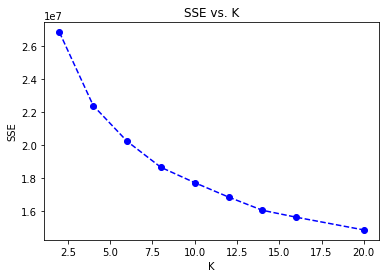

In [28]:
# Over a number of different cluster counts...
# Investigate the change in within-cluster distance across number of clusters

scores = []
cluster_counts = [2, 4, 6, 8, 10, 12, 14, 16, 20]

for cluster_count in cluster_counts:
    # instantiate a model with cluster_count clusters
    kmeans = KMeans(cluster_count)
    
    # fit the model to the scaled PCA-transformed data
    model = kmeans.fit(clean_azdias_ss_pca)
    
    # predict the labels on the same data to show the category that point belongs to
    labels = model.predict(clean_azdias_ss_pca)
    
    # compute the average within-cluster distances.
    # Obtain a score related to the model fit
    score = np.abs(model.score(clean_azdias_ss_pca))
    
    print('For {} clusters, score = {}'.format(cluster_count, score))
    scores.append(score)


plt.plot(cluster_counts, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

Based on the scree plot, I sugggest using 4 (first elbow) or 14 clusters (second major elbow).
Because the algorithm is taking long to execute, I choose 4 clusters.

In [29]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

cluster_count = 4
kmeans = KMeans(cluster_count)
model = kmeans.fit(clean_azdias_ss_pca)
labels = model.predict(clean_azdias_ss_pca)
score = np.abs(model.score(clean_azdias_ss_pca))


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [30]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', sep=';')

In [31]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
clean_customers = clean_data(customers)

In [32]:
clean_customers.shape

(115643, 64)

In [33]:
customers.shape

(191652, 85)

In [38]:
clean_customers.isna().sum().sum()

0

In [46]:
clean_customers.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,4.0,1.0,5.0,1.0,5.0,1.0,2.0,2.0,1.0,1.0,...,0.0,5.0,5.0,1.0,2.0,1.0,50,2,1,3
2,4.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,1.0,2.0,...,1.0,3.0,2.0,3.0,5.0,3.0,50,2,3,4
4,3.0,1.0,3.0,1.0,4.0,4.0,5.0,2.0,0.0,3.0,...,1.0,3.0,3.0,3.0,5.0,1.0,70,1,4,1
5,3.0,1.0,5.0,1.0,5.0,1.0,2.0,3.0,1.0,3.0,...,1.0,5.0,5.0,3.0,7.0,5.0,50,2,3,4
6,4.0,1.0,5.0,1.0,5.0,1.0,1.0,2.0,1.0,2.0,...,0.0,5.0,5.0,2.0,3.0,2.0,50,2,2,3


In [47]:
# Fit and transform the data
clean_customers_ss = p.StandardScaler().fit_transform(clean_customers) 

In [48]:
# Apply PCA to the data while selecting for 21 components to retain.
n_components = 21
pca = PCA(n_components)
clean_customers_ss_pca = pca.fit_transform(clean_customers_ss)

In [49]:
clean_customers_ss = pd.DataFrame(clean_customers_ss)
clean_customers_ss.columns = clean_customers.columns
clean_customers_ss.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,0.695345,-0.691442,0.712637,-0.49594,0.492276,-0.574838,0.220190,-0.596238,0.938625,-1.245832,...,-0.851404,1.479191,1.379133,-1.826652,-1.465423,-1.353193,-0.640226,0.938625,-1.140343,-0.296595
1,0.695345,1.446252,0.712637,-0.49594,0.492276,-0.574838,2.373089,0.952626,0.938625,0.059970,...,0.715440,-0.683186,-1.600931,0.162280,-0.075625,0.055181,-0.640226,0.938625,0.279880,0.451379
2,-0.781455,-0.691442,-1.281229,-0.49594,-0.727293,2.552022,3.449539,-0.596238,-1.065389,1.365772,...,0.715440,-0.683186,-0.607576,0.162280,-0.075625,-1.353193,0.878059,-1.065389,0.989992,-1.792543
3,-0.781455,-0.691442,0.712637,-0.49594,0.492276,-0.574838,0.220190,0.178194,0.938625,1.365772,...,0.715440,1.479191,1.379133,0.162280,0.850907,1.463556,-0.640226,0.938625,0.279880,0.451379
4,0.695345,-0.691442,0.712637,-0.49594,0.492276,-0.574838,-0.856260,-0.596238,0.938625,0.059970,...,-0.851404,1.479191,1.379133,-0.832186,-1.002157,-0.649006,-0.640226,0.938625,-0.430232,-0.296595


In [50]:
customer_components = pd.DataFrame(np.round(pca.components_, 4), columns = clean_customers_ss.keys())
# components = pd.DataFrame(np.round(pca.components_, 4), columns = clean_azdias_ss.keys())

In [51]:
customer_components
# components 

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,DECADE,MOVEMENT,WEALTH,LIFE_STAGE
0,-0.0173,0.1441,-0.2408,0.0386,-0.0234,0.0157,-0.0137,0.2204,-0.1126,0.0209,...,0.2004,0.0213,-0.1610,0.1365,0.1748,0.1352,-0.0008,-0.1126,0.1914,-0.0757
1,-0.0160,-0.3101,0.0436,-0.0256,0.0263,-0.1523,-0.0120,-0.0020,0.0675,-0.0383,...,0.1233,0.0329,-0.0800,0.0989,0.1439,0.1013,-0.0495,0.0675,0.0526,-0.0088
2,-0.3216,-0.0115,-0.1028,0.3181,-0.3114,0.2604,0.2155,-0.1098,-0.0578,0.1762,...,0.0050,-0.0074,-0.0109,-0.0215,-0.0283,-0.0232,0.3088,-0.0578,0.0206,-0.0664
3,0.0791,-0.1273,-0.0669,-0.0137,0.0332,0.0729,-0.0876,0.0860,-0.3678,-0.0091,...,-0.0470,-0.0731,-0.0211,-0.1591,-0.2456,-0.1510,-0.0331,-0.3678,0.1436,-0.1123
4,-0.0710,0.0531,-0.0708,-0.0529,0.0736,-0.0761,-0.0202,0.1062,-0.0273,-0.0364,...,0.0290,0.4229,0.3320,-0.2136,-0.1400,-0.1890,-0.0677,-0.0273,-0.0318,0.0270
5,0.2761,-0.0028,-0.0849,0.2551,-0.2608,0.2121,0.2307,-0.0863,0.0740,-0.2843,...,0.0697,0.1752,0.0887,-0.0256,-0.0021,-0.0192,0.2167,0.0740,0.0320,-0.0416
6,0.0215,0.0639,-0.0794,0.0309,-0.0538,0.0276,0.0079,0.0593,0.0244,-0.1895,...,-0.0093,-0.3563,-0.2815,-0.1477,-0.1075,-0.1104,0.0092,0.0244,-0.0842,0.1132
7,-0.0287,-0.0583,0.0196,-0.0015,-0.0045,-0.0097,-0.0075,-0.0668,0.0247,0.1567,...,0.0346,0.1590,0.1148,0.0474,0.1024,0.0078,0.0167,0.0247,-0.0660,0.1235
8,-0.0171,0.0120,0.0898,-0.1754,0.2036,-0.1074,-0.2113,0.0131,0.0081,0.0874,...,0.1043,-0.0209,-0.1056,-0.1280,-0.0733,-0.0570,-0.0404,0.0081,0.0771,-0.1369
9,0.0257,-0.0516,0.0535,0.0825,-0.0240,-0.0371,0.2562,-0.1387,0.1157,0.1667,...,-0.0047,-0.1287,-0.1235,-0.2373,-0.0849,-0.0296,0.0372,0.1157,0.0736,-0.1441


In [52]:
pca.explained_variance_ratio_

array([ 0.1614365 ,  0.09962659,  0.09553252,  0.06041683,  0.03949105,
        0.03452968,  0.03324387,  0.02951498,  0.02473467,  0.02110418,
        0.0195391 ,  0.01877353,  0.01756619,  0.01630674,  0.01562234,
        0.01509279,  0.01458986,  0.0141243 ,  0.01390616,  0.01326357,
        0.01296548])

In [42]:
pca.explained_variance_ratio_

array([ 0.17412295,  0.13698058,  0.0964338 ,  0.05361775,  0.03754851,
        0.03201816,  0.02835135,  0.02482454,  0.02358918,  0.0213909 ,
        0.02046456,  0.01908535,  0.01829969,  0.01670446,  0.01613754,
        0.01561791,  0.01482123,  0.01433811,  0.01321953,  0.01285038,
        0.01259193])

In [54]:
customers_labels = model.predict(clean_customers_ss_pca)


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [ ]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.



In [ ]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?



In [ ]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?



### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.